# Jingju Stytle Music Generation Using Feedforward VAE.

Author: Huicheng Zhang

Aim: To generate a piece of jingju style music.

Presentation Slides: https://docs.google.com/presentation/d/1cr9diuP46ICYP4gxFeWCh6iDurWOo7xukD--vPwBsYM/edit?usp=sharing

## Package Installation

In [ ]:
! git clone 'https://github.com/felixCheungcheung/CMC_final_project.git'
!cd "CMC_final_project"

Cloning into 'CMC_final_project'...
remote: Enumerating objects: 601, done.
remote: Counting objects: 100% (601/601), done.
remote: Compressing objects: 100% (484/484), done.
remote: Total 601 (delta 127), reused 577 (delta 114), pack-reused 0
Receiving objects: 100% (601/601), 255.84 MiB | 28.31 MiB/s, done.
Resolving deltas: 100% (127/127), done.
Checking out files: 100% (256/256), done.


In [ ]:
!apt install musescore fluidsynth
!cp /usr/share/sounds/sf2/FluidR3_GM.sf2 ./font.sf2

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  avahi-daemon bind9-host desktop-file-utils fluid-soundfont-gm
  fluidr3mono-gm-soundfont geoclue-2.0 geoip-database
  gstreamer1.0-plugins-base iio-sensor-proxy libavahi-core7 libavahi-glib1
  libbind9-160 libbrotli1 libcap2-bin libcdparanoia0 libdaemon0 libdns1100
  libfluidsynth1 libgeoclue-2-0 libgeoip1 libgl1-mesa-glx
  libgstreamer-plugins-base1.0-0 libgstreamer1.0-0 libhyphen0 libisc169
  libisccc160 libisccfg160 liblwres160 libmbim-glib4 libmbim-proxy libmm-glib0
  libnl-genl-3-200 libnss-mdns liborc-0.4-0 libpam-cap libportaudio2
  libpulsedsp libqmi-glib5 libqmi-proxy libqt5help5 libqt5positioning5
  libqt5qml5 libqt5quick5 libqt5sensors5 libqt5sql5-sqlite libqt5svg5
  libqt5webchannel5 libqt5webkit5 libqt5x11extras5 libqt5xmlpatterns5
  libvisual-0.4-0 libwoff1 modemmanager musescore-common pulseaudio-utils
  qml-module-qtgraph

In [ ]:
pip install torch muspy numpy pypianoroll fluidsynth midi2audio

     |████████████████████████████████| 107 kB 13.1 MB/s 
     |████████████████████████████████| 5.6 MB 25.2 MB/s 
     |████████████████████████████████| 51 kB 7.5 MB/s 
  Created wheel for pretty-midi: filename=pretty_midi-0.2.9-py3-none-any.whl size=5591955 sha256=eb0ae3f4fae44016a4f9065361001e8efd6ce78857caf7badbb1b6717e6f5995
  Stored in directory: /root/.cache/pip/wheels/ad/74/7c/a06473ca8dcb63efb98c1e67667ce39d52100f837835ea18fa
  Created wheel for fluidsynth: filename=fluidsynth-0.2-py3-none-any.whl size=4513 sha256=2bea2462b97d1540da777665c0517861fdcb98ec22e11191631af2736cbc5d29
  Stored in directory: /root/.cache/pip/wheels/44/4b/81/dee2d535b2dd27af13c230ba49aa6f05a5dff0f57c68acef55
Successfully built pretty-midi fluidsynth


In [ ]:
import muspy
import os
import torch
import numpy as np
import pypianoroll
from pypianoroll import Multitrack, Track
from pretty_midi import PrettyMIDI
from midi2audio import FluidSynth
from IPython.display import Audio
import matplotlib.pyplot as plt
import random
from torch.utils.tensorboard import SummaryWriter


writer = SummaryWriter()
jingju_path = 'CMC_final_project/data/Jingju Scores Dataset/MusicXML/'

# Colab cannot play music directly from music21 - must convert to .wav first
def play_wav(out_midi):
    out_wav = out_midi.replace('.mid','.wav')
    FluidSynth("font.sf2").midi_to_audio(out_midi, out_wav)
    return Audio(out_wav)
    
# Create a directory if not exists
sample_dir = 'samples'

if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

In [ ]:
muspy.download_bravura_font()
muspy.download_musescore_soundfont()

Start downloading Bravura font.
Bravura font has successfully been downloaded to : /root/.muspy/musescore-general.
Start downloading MuseScore General soundfont.
MuseScore General soundfont has successfully been downloaded to : /root/.muspy/musescore-general.


## Dataset Creation and some prepoccessing

In [ ]:
# User-defined parameters
lowest_pitch = 48 # C3
n_pitches = 24 # 2 octaves
expect_len = 8 # length of training sample (Unit:beat)

In [ ]:
from torch.functional import Tensor
# data preparation
# use beat_resolution to select notes
data = []
beat_resolution = 8 # number of time steps per beat

"For a first approach to the results, we grouped the banshi \
in three groups: yuanban and erliu, in 2/4 metre and \
medium tempo ranges; manban, sanyan, zhongsanyan and \
kuaisanyan, in 4/4 metre and slower tempo ranges than the \
previous group; and kuaiban and liushui, in 1/4 metre and \
faster tempo ranges than the first group. "
fixed_len = expect_len * beat_resolution
# it is actually a length of 8 beat, the concept of measure does not fit jingju since the dataset contains different rhymic pattern 
for file in os.listdir(jingju_path):
  
  if file.split('.')[-1] not in ['xml','musicxml']:
    print(f"Neglecting {file}")
    continue
  song = muspy.read_musicxml(os.path.join(jingju_path,file))
  multitrack = muspy.to_pypianoroll(song)
  multitrack.binarize()
  multitrack.set_resolution(beat_resolution)
  
  pianoroll = multitrack.stack() >0 # return 3D array, boolean
  pianoroll = pianoroll[:,:,lowest_pitch:lowest_pitch + n_pitches]
  # stack mulitrack into one track
  pianoroll = np.any(pianoroll,axis=0)

  # fixed length slicing window, hop size = one beat
  n_total_units = multitrack.get_max_length() // beat_resolution
  

  if n_total_units == 1:
    data.append(pianoroll[:fixed_len])
  else:
    # Randomly select a number of phrases from the multitrack pianoroll
    for idx in range(n_total_units - fixed_len +1):
      start = idx * beat_resolution
      end = start + fixed_len
      # Skip the samples where some track(s) has too few notes
      if (pianoroll.sum(axis=(0,1)) < 10).any():
        print("too few notes")
        continue
      data.append(pianoroll[start:end])
random.shuffle(data)
print(np.shape(data))
data = np.stack(data)


(20406, 64, 24)


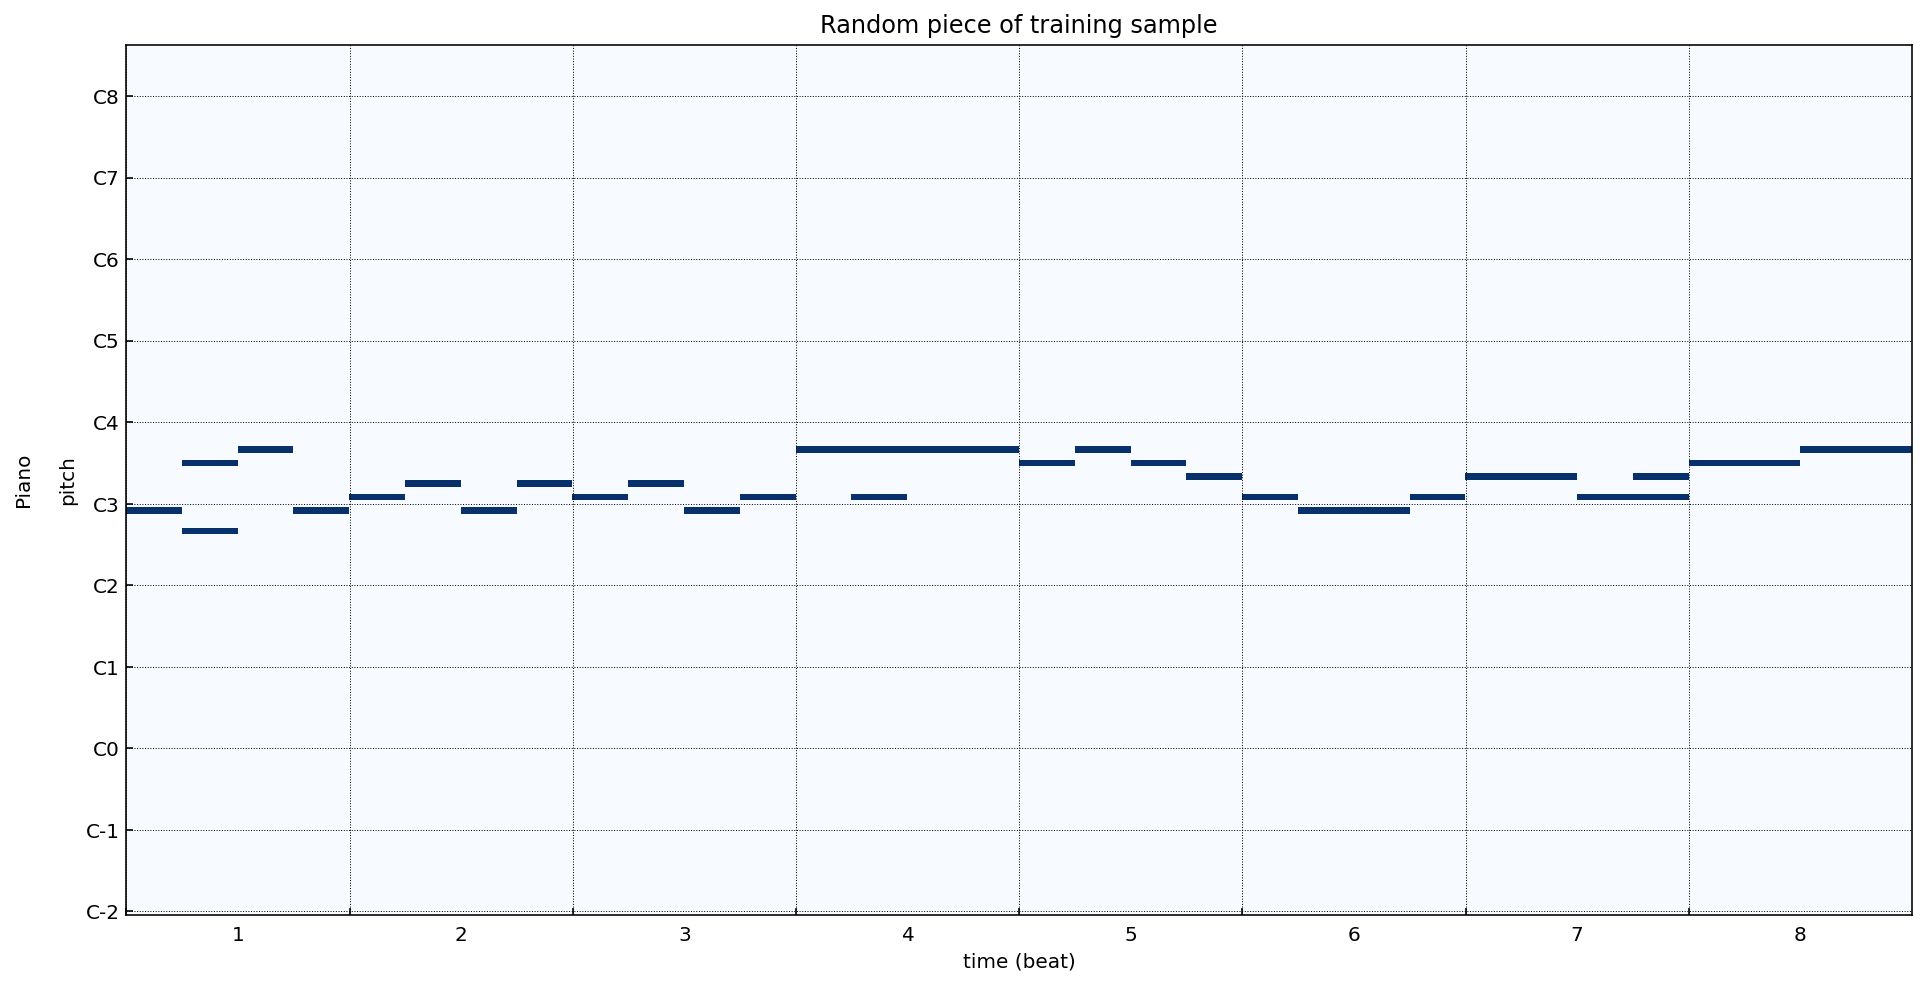

In [ ]:
# visualize an example of training samples
# Write a midi file of a training sample

tracks = []
programs = 1  # program number for each track
is_drums = False  # drum indicator for each track
track_names = 'Piano'  # name of each track
tempo = 60

tempo_array = np.full((data.shape[1], 1), tempo)

random_idx = random.choice(range(0,(len(data))))
pianoroll = np.pad(np.concatenate(data[random_idx:random_idx + 1]), ((0, 0), (lowest_pitch, 128 - lowest_pitch - n_pitches)))
tracks.append(Track(name=track_names, program=programs, is_drum=is_drums, pianoroll=pianoroll))
multitrack = Multitrack(tracks=tracks, tempo=tempo_array, resolution=beat_resolution)
train_sample = muspy.from_pypianoroll(multitrack)
for note in train_sample.tracks[0].notes:
  # note.duration = 1
  note.velocity = 64
train_midi_sample = 'samples/train_sample.mid'
muspy.write(train_midi_sample,train_sample)


axs = multitrack.plot()
plt.gcf().set_size_inches((16, 8))
plt.title("Random piece of training sample")
plt.show()

In [ ]:
play_wav(train_midi_sample)

### Term Explained:
Kuaiban(Allegro): with short duration and dense notes, 1/4 meter, expressing happiness and nervousness.

Manban(Adagio): Less notes and longer duration, 4/4 meter.

Yuanban: Moderate, 2/4 meter

Shengqiang: 1)Limited stock of melodic lines "characteristic pitch progressions" 2) Music system

Reference: Caro Repetto, Rafael. (2018). The musical dimension of Chinese traditional theatre: An analysis from computer aided musicology [Zenodo]. https://doi.org/10.5281/zenodo.2030600

In [ ]:
#TODO: MODEL DESIGN; ONLY CONSIDER MELODY

import torch.nn as nn
import torch.nn.functional as F

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper-parameters
h1_dim = 1500
h2_dim = 1000
h3_dim = 400
z_dim = 64

batch_size = 128
learning_rate = 1e-3

input_size = n_pitches * fixed_len 

# Data loader
data = torch.as_tensor(data, dtype=torch.float32)
dataset = torch.utils.data.TensorDataset(data)
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, drop_last=True, shuffle=True)

# VAE model
class VAE(nn.Module):
  def __init__(self, input_size, h1_dim, h2_dim, h3_dim, z_dim):

    super(VAE, self).__init__()
    self.fc1 = nn.Linear(input_size, h1_dim)
    self.fc2 = nn.Linear(h1_dim, h2_dim)
    self.fc3 = nn.Linear(h2_dim, h3_dim)
    self.fc4 = nn.Linear(h3_dim, z_dim)
    self.fc5 = nn.Linear(h3_dim, z_dim)
    self.fc6 = nn.Linear(z_dim, h3_dim)
    self.fc7 = nn.Linear(h3_dim, h2_dim)
    self.fc8 = nn.Linear(h2_dim, h1_dim)
    self.fc9 = nn.Linear(h1_dim, input_size)
      
      
  def encode(self, x):
    h1 = F.relu(self.fc1(x))
    h2 = F.relu(self.fc2(h1))
    h3 = F.relu(self.fc3(h2))
    return self.fc4(h3), self.fc5(h3)
  
  def reparameterize(self, mu, log_var):
    std = torch.exp(log_var/2)
    eps = torch.randn_like(std)
    return mu + eps * std

  def decode(self, z):
    h3 = F.relu(self.fc6(z))
    h2 = F.relu(self.fc7(h3))
    h1 = F.relu(self.fc8(h2))
    return F.sigmoid(self.fc9(h1))
  
  def forward(self, x):
      
    mu, log_var = self.encode(x)
    z = self.reparameterize(mu, log_var)
    x_reconst = self.decode(z)
    return x_reconst, mu, log_var

  def loss_function(self, recon_x, x, mu, logvar):

    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE, KLD
  def train_loop(self, optimizer, train_loader, epoch, num_epoch, writer,log_interval=10):
    self.train()
    train_loss = 0
    for batch_idx, data in enumerate(train_loader):
      optimizer.zero_grad()
  
      data = data[0].to(device).view(-1, input_size)
      x_reconst, mu, log_var = self.forward(data)
      BCE, KLD = self.loss_function(x_reconst, data, mu, log_var)
      loss = BCE + KLD
      loss.backward()
      train_loss += loss.item()
      optimizer.step()

    # print(f'Train Epoch: [{epoch+1}/{num_epoch}],[{batch_idx+1}/{len(train_loader)}]\tReconst_Loss: {BCE.item():.6f}\tKCL_loss: {KLD.item():.6f}')
  
    average_loss = train_loss / len(train_loader)
    print(f"====> Epoch: {epoch+1} Average loss: {average_loss:.4f}\tReconst_Loss: {BCE.item():.6f}\tKCL_loss: {KLD.item():.6f}")
    writer.add_scalar("Average_Loss/train",average_loss,epoch)
    return average_loss


## Load pre-trained model

In [ ]:

model = VAE(input_size, h1_dim=h1_dim, h2_dim=h2_dim, h3_dim=h3_dim, z_dim=z_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# Uncomment to load previous model
# checkpoint = torch.torch.load("CMC_final_project/model/best_model_1000epoch_8_beat.pyt",map_location=device)
# model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

## Train the model for the first time (Don't do that if you just want to listen to the demo)

In [ ]:
model = VAE(input_size, h1_dim=h1_dim, h2_dim=h2_dim, h3_dim=h3_dim, z_dim=z_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
num_epochs = 1000

# Start training
for epoch in range(num_epochs):
  average_loss = model.train_loop(optimizer,data_loader,epoch,num_epochs,writer,log_interval=100)
  



/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


====> Epoch: 1 Average loss: 26138.0964	Reconst_Loss: 22076.292969	KCL_loss: 246.090851
====> Epoch: 2 Average loss: 22386.6085	Reconst_Loss: 21321.644531	KCL_loss: 463.834167
====> Epoch: 3 Average loss: 21761.6485	Reconst_Loss: 20099.851562	KCL_loss: 457.152771
====> Epoch: 4 Average loss: 21230.7784	Reconst_Loss: 20203.853516	KCL_loss: 508.742737
====> Epoch: 5 Average loss: 20904.5778	Reconst_Loss: 19303.599609	KCL_loss: 599.773560
====> Epoch: 6 Average loss: 20626.2296	Reconst_Loss: 19034.898438	KCL_loss: 571.770691
====> Epoch: 7 Average loss: 20440.7118	Reconst_Loss: 20098.677734	KCL_loss: 711.511230
====> Epoch: 8 Average loss: 20177.2086	Reconst_Loss: 19908.849609	KCL_loss: 715.619141
====> Epoch: 9 Average loss: 19951.1408	Reconst_Loss: 18301.892578	KCL_loss: 765.901978
====> Epoch: 10 Average loss: 19748.6302	Reconst_Loss: 18652.470703	KCL_loss: 791.013550
====> Epoch: 11 Average loss: 19557.5958	Reconst_Loss: 18969.066406	KCL_loss: 864.364014
====> Epoch: 12 Average loss: 

In [ ]:
torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict()
},f"CMC_final_project/model/best_model_{epoch+1}epoch_{expect_len}_beat.pyt")

## Evaluation

In [ ]:
# Evaluation
with torch.no_grad():
  wish_len = int(input("Enter the length of music that you want to generate(multiple number of expect_len (4) ):")) 
  generate_len = int(wish_len/ expect_len)
  z = torch.randn(generate_len, z_dim).to(device)
  out = model.decode(z).reshape(z.shape[0],fixed_len,n_pitches)
  

Enter the length of music that you want to generate(multiple number of expect_len (4) ):16


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [ ]:
# Feel free to play with this parameter

threshold = 0.1 # You can change it from 0.05-0.9

# mask = out.ge(threshold)
# predictions = out * mask.int().float()
# First filter the notes below threshold
predictions = out.ge(threshold)

# Uncomment Below to generate single line melody
# most_probable = torch.argmax(out,dim=2)

# predictions = torch.nn.functional.one_hot(most_probable, n_pitches)

# predictions = predictions.type(dtype=torch.float32)

out_cpu = predictions.to(torch.device("cpu")).numpy()
print(np.shape(out_cpu))

(2, 64, 24)


Enter the desired BPM(Recommend:60): 50


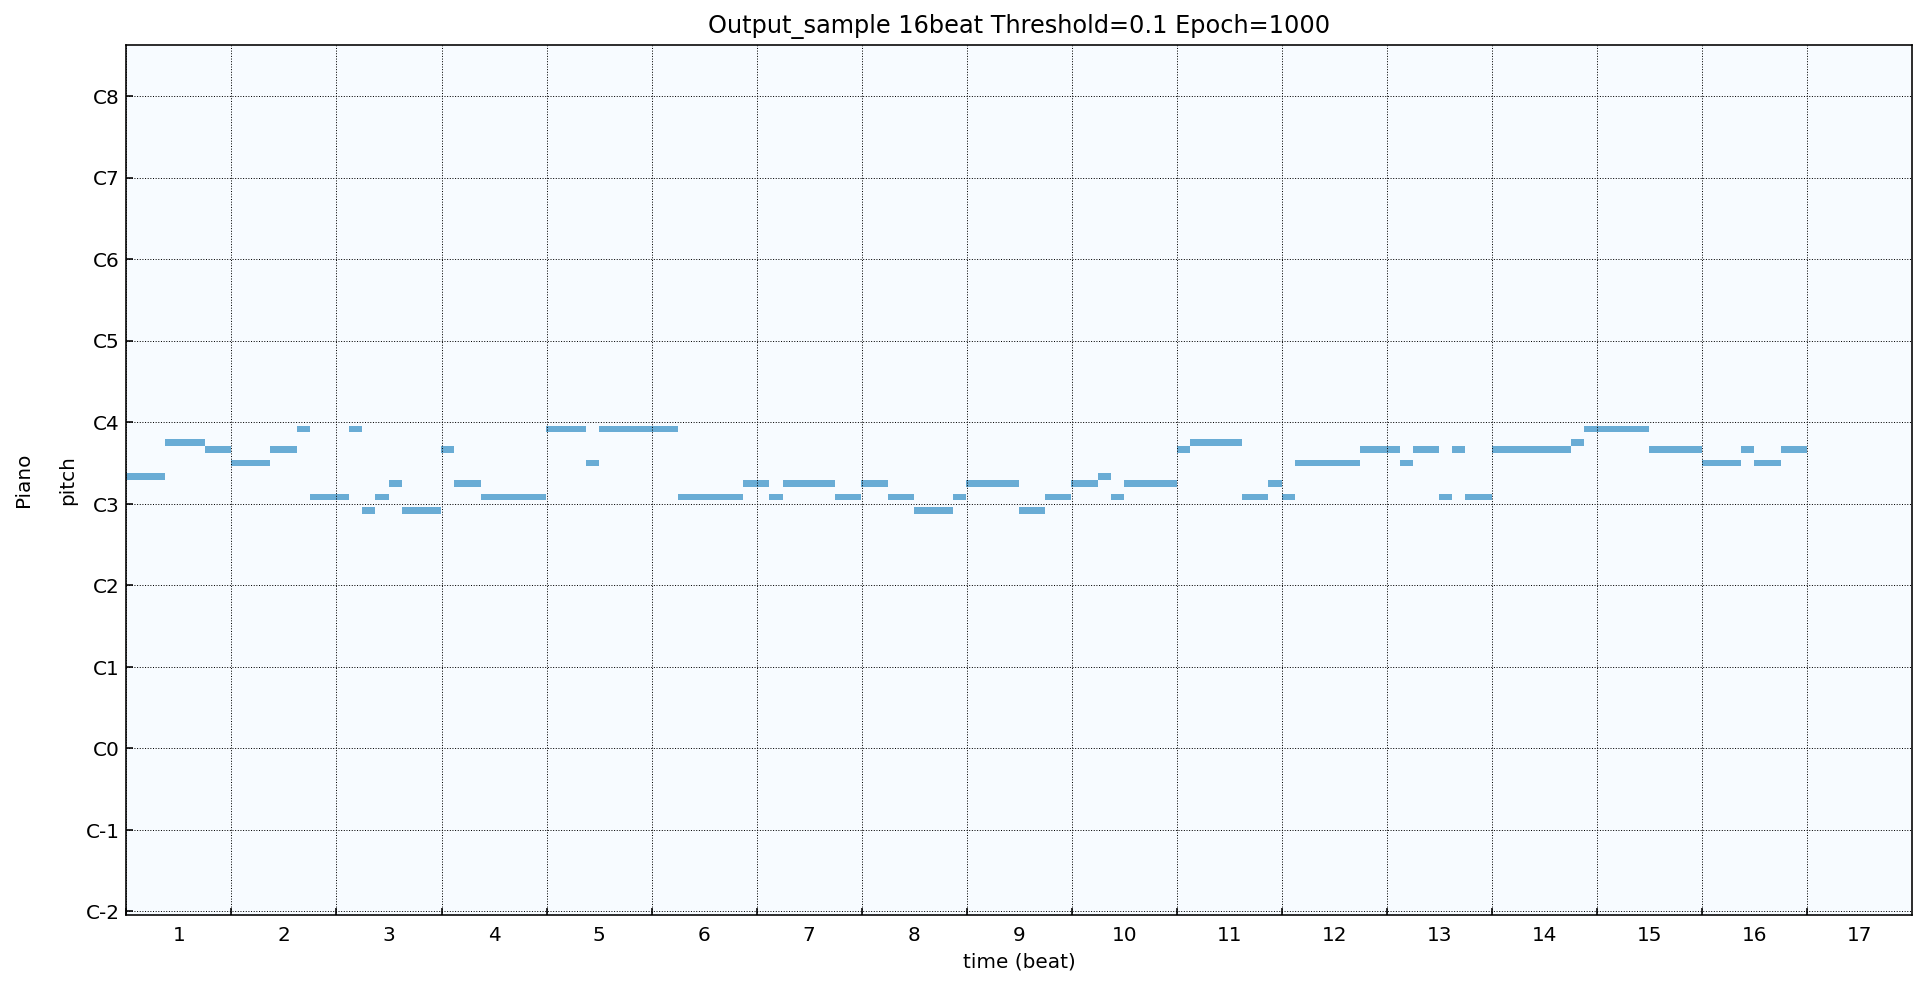

In [ ]:
# Visualization of a sample
# Show the source xml file name

tracks = []
programs = 1  # program number for each track
is_drums = False  # drum indicator for each track
track_names = 'Piano'  # name of each track
banshi_list = ['manban', 'zhongsanyan', 'yuanban', 'kuaisanyan', 'yaoban', '--', 'daoban', 'erliu', 'liushui', 'sanban', 'kuaiban', 'sanyan', 'kuai’erliu']
tempo = input("Enter the desired BPM(Recommend:60): ")
tempo_array = np.full((out_cpu.shape[1] * generate_len, 1), tempo)

# the first dimension is batch

pianoroll = np.pad(np.concatenate(out_cpu), ((0,0), (lowest_pitch, 128 - lowest_pitch - n_pitches)))
tracks.append(Track(name=track_names, program=programs, is_drum=is_drums, pianoroll=pianoroll))
multitrack = Multitrack(tracks=tracks, tempo=tempo_array, resolution=beat_resolution)
output_sample = muspy.from_pypianoroll(multitrack)

# Post processing: 
for idx,note in enumerate(output_sample.tracks[0].notes):
  note.velocity = 64
  
  # Octave Error Elimination
  while note.pitch < lowest_pitch:
    note.pitch = note.pitch + 12
  while note.pitch > lowest_pitch + n_pitches:
    note.pitch = note.pitch - 12
  if idx+1 < len(output_sample.tracks[0].notes) and idx!=0:
    if note.pitch - output_sample.tracks[0].notes[idx-1].pitch ==-12 and (note.pitch - output_sample.tracks[0].notes[idx+1].pitch)==-12:
      print("Found")
      # output_sample.tracks[0].notes[idx-1].time = output_sample.tracks[0].notes[idx-1].time +note.time
      note.pitch = output_sample.tracks[0].notes[idx-1].pitch
  


multitrack = muspy.to_pypianoroll(output_sample)
axs = multitrack.plot()
plt.gcf().set_size_inches((16, 8))
plt.title(f'Output_sample {wish_len}beat Threshold={threshold} Epoch={1000}')
plt.show()




In [ ]:
# Demo: 
output_midi_file = f'samples/output_sample_{wish_len}_thres{threshold}.mid'
muspy.write(output_midi_file,output_sample)
play_wav(output_midi_file)